In [1]:

import datetime
import numpy as np
import cv2
from itertools import cycle
import pickle
import pathlib
import math
import tqdm
import scipy.io
from matplotlib import pyplot as plt
import scipy.io
import h5py
import re
from lxml import etree as ET
import scipy.signal as sig
import pandas as pd
from scipy.stats import kde
from BlockSync_current import BlockSync
import UtilityFunctions_newOE as uf
from scipy import signal
import bokeh
import seaborn as sns
from matplotlib import rcParams

rcParams['pdf.fonttype'] = 42  # Ensure fonts are embedded and editable
rcParams['ps.fonttype'] = 42  # Ensure compatibility with vector outputs
%matplotlib inline

def bokeh_plotter(data_list, x_axis_list=None, label_list=None,
                  plot_name='default',
                  x_axis_label='X', y_axis_label='Y',
                  peaks=None, peaks_list=False, export_path=False):
    """Generates an interactive Bokeh plot for the given data vector.
    Args:
        data_list (list or array): The data to be plotted.
        label_list (list of str): The labels of the data vectors
        plot_name (str, optional): The title of the plot. Defaults to 'default'.
        x_axis (str, optional): The label for the x-axis. Defaults to 'X'.
        y_axis (str, optional): The label for the y-axis. Defaults to 'Y'.
        peaks (list or array, optional): Indices of peaks to highlight on the plot. Defaults to None.
        export_path (False or str): when set to str, will output the resulting html fig
    """
    color_cycle = cycle(bokeh.palettes.Category10_10)
    fig = bokeh.plotting.figure(title=f'bokeh explorer: {plot_name}',
                                x_axis_label=x_axis_label,
                                y_axis_label=y_axis_label,
                                plot_width=1500,
                                plot_height=700)

    for i, data_vector in enumerate(data_list):

        color = next(color_cycle)

        if x_axis_list is None:
            x_axis = range(len(data_vector))
        elif len(x_axis_list) == len(data_list):
            print('x_axis manually set')
            x_axis = x_axis_list[i]
        else:
            raise Exception(
                'problem with x_axis_list input - should be either None, or a list with the same length as data_list')
        if label_list is None:
            fig.line(x_axis, data_vector, line_color=color, legend_label=f"Line {i + 1}")
        elif len(label_list) == len(data_list):
            fig.line(range(len(data_vector)), data_vector, line_color=color, legend_label=f"{label_list[i]}")
        if peaks is not None and peaks_list is True:
            fig.circle(peaks[i], data_vector[peaks[i]], size=10, color=color)

    if peaks is not None and peaks_list is False:
        fig.circle(peaks, data_vector[peaks], size=10, color='red')

    if export_path is not False:
        print(f'exporting to {export_path}')
        bokeh.io.output.output_file(filename=str(export_path / f'{plot_name}.html'), title=f'{plot_name}')
    bokeh.plotting.show(fig)


def load_eye_data_2d_w_rotation_matrix(block):
    """
    This function checks if the eye dataframes and rotation dict object exist, then imports them
    :param block: The current blocksync class with verifiec re/le dfs
    :return: None
    """
    try:
        block.left_eye_data = pd.read_csv(block.analysis_path / 'left_eye_data.csv', index_col=0, engine='python')
        block.right_eye_data = pd.read_csv(block.analysis_path / 'right_eye_data.csv', index_col=0, engine='python')
    except FileNotFoundError:
        print('eye_data files not found, run the pipeline!')
        return

    try:
        with open(block.analysis_path / 'rotate_eye_data_params.pkl', 'rb') as file:
            rotation_dict = pickle.load(file)
            block.left_rotation_matrix = rotation_dict['left_rotation_matrix']
            block.right_rotation_matrix = rotation_dict['right_rotation_matrix']
            block.left_rotation_angle = rotation_dict['left_rotation_angle']
            block.right_rotation_angle = rotation_dict['right_rotation_angle']
    except FileNotFoundError:
        print('No rotation matrix file, create it')


def create_saccade_events_df(eye_data_df, speed_threshold, bokeh_verify_threshold=False, magnitude_calib=1,
                             speed_profile=True):
    """
    Detects saccade events in eye tracking data and computes relevant metrics.

    Parameters:
    - eye_data_df (pd.DataFrame): Input DataFrame containing eye tracking data.
    - speed_threshold (float): Threshold for saccade detection based on speed.

    Returns:
    - df (pd.DataFrame): Modified input DataFrame with added columns for speed and saccade detection.
    - saccade_events_df (pd.DataFrame): DataFrame containing information about detected saccade events.

    Steps:
    1. Calculate speed components ('speed_x', 'speed_y') based on differences in 'center_x' and 'center_y'.
    2. Compute the magnitude of the velocity vector ('speed_r').
    3. Create a binary column ('is_saccade') indicating saccade events based on the speed threshold.
    4. Determine saccade onset and offset indices and timestamps.
    5. Create a DataFrame ('saccade_events_df') with columns:
        - 'saccade_start_ind': Indices of saccade onset.
        - 'saccade_start_timestamp': Timestamps corresponding to saccade onset.
        - 'saccade_end_ind': Indices of saccade offset.
        - 'saccade_end_timestamp': Timestamps corresponding to saccade offset.
        - 'length': Duration of each saccade event.
    6. Calculate distance traveled and angles for each saccade event.
    7. Append additional columns to 'saccade_events_df':
        - 'magnitude': Magnitude of the distance traveled during each saccade.
        - 'angle': Angle of the saccade vector in degrees.
        - 'initial_x', 'initial_y': Initial coordinates of the saccade.
        - 'end_x', 'end_y': End coordinates of the saccade.

    Note: The original 'eye_data_df' is not modified; modified data is returned as 'df'.
    """
    df = eye_data_df
    df['speed_x'] = df['center_x'].diff()  # Difference between consecutive 'center_x' values
    df['speed_y'] = df['center_y'].diff()  # Difference between consecutive 'center_y' values

    # Step 2: Calculate magnitude of the velocity vector (R vector speed)
    df['speed_r'] = (df['speed_x'] ** 2 + df['speed_y'] ** 2) ** 0.5

    # Create a column for saccade detection
    df['is_saccade'] = df['speed_r'] > speed_threshold

    # create a saccade_on_off indicator where 1 is rising edge and -1 is falling edge by subtracting a shifted binary mask
    saccade_on_off = df.is_saccade.astype(int) - df.is_saccade.shift(periods=1, fill_value=False).astype(int)
    saccade_on_inds = np.where(saccade_on_off == 1)[
                          0] - 1  # notice the manual shift here, chosen to include the first (sometimes slower) eye frame, just before saccade threshold crossing
    saccade_on_ms = df['ms_axis'].iloc[saccade_on_inds]
    saccade_on_timestamps = df['OE_timestamp'].iloc[saccade_on_inds]
    saccade_off_inds = np.where(saccade_on_off == -1)[0]
    saccade_off_timestamps = df['OE_timestamp'].iloc[saccade_off_inds]
    saccade_off_ms = df['ms_axis'].iloc[saccade_off_inds]

    saccade_dict = {'saccade_start_ind': saccade_on_inds,
                    'saccade_start_timestamp': saccade_on_timestamps.values,
                    'saccade_end_ind': saccade_off_inds,
                    'saccade_end_timestamp': saccade_off_timestamps.values,
                    'saccade_on_ms': saccade_on_ms.values,
                    'saccade_off_ms': saccade_off_ms.values}

    saccade_events_df = pd.DataFrame.from_dict(saccade_dict)
    saccade_events_df['length'] = saccade_events_df['saccade_end_ind'] - saccade_events_df['saccade_start_ind']
    # Drop columns used for intermediate steps
    df = df.drop(['is_saccade'], axis=1)

    distances = []
    angles = []
    speed_list = []
    diameter_list = []
    for index, row in tqdm.tqdm(saccade_events_df.iterrows()):
        saccade_samples = df.loc[(df['OE_timestamp'] >= row['saccade_start_timestamp']) &
                                 (df['OE_timestamp'] <= row['saccade_end_timestamp'])]
        distance_traveled = saccade_samples['speed_r'].sum()
        if speed_profile:
            saccade_speed_profile = saccade_samples['speed_r'].values
            speed_list.append(saccade_speed_profile)
        saccade_diameter_profile = saccade_samples['pupil_diameter'].values
        diameter_list.append(saccade_diameter_profile)
        # Calculate angle from initial position to endpoint
        initial_position = saccade_samples.iloc[0][['center_x', 'center_y']]
        endpoint = saccade_samples.iloc[-1][['center_x', 'center_y']]
        overall_angle = np.arctan2(endpoint['center_y'] - initial_position['center_y'],
                                   endpoint['center_x'] - initial_position['center_x'])

        angles.append(overall_angle)
        distances.append(distance_traveled)

    saccade_events_df['magnitude_raw'] = np.array(distances)
    saccade_events_df['magnitude'] = np.array(distances) * magnitude_calib
    saccade_events_df['angle'] = np.where(np.isnan(angles), angles, np.rad2deg(
        angles) % 360)  # Convert radians to degrees and ensure result is in [0, 360)
    start_ts = saccade_events_df['saccade_start_timestamp'].values
    end_ts = saccade_events_df['saccade_end_timestamp'].values
    saccade_start_df = df[df['OE_timestamp'].isin(start_ts)]
    saccade_end_df = df[df['OE_timestamp'].isin(end_ts)]
    start_x_coord = saccade_start_df['center_x']
    start_y_coord = saccade_start_df['center_y']
    end_x_coord = saccade_end_df['center_x']
    end_y_coord = saccade_end_df['center_y']
    saccade_events_df['initial_x'] = start_x_coord.values
    saccade_events_df['initial_y'] = start_y_coord.values
    saccade_events_df['end_x'] = end_x_coord.values
    saccade_events_df['end_y'] = end_y_coord.values
    saccade_events_df['calib_dx'] = (saccade_events_df['end_x'].values - saccade_events_df[
        'initial_x'].values) * magnitude_calib
    saccade_events_df['calib_dy'] = (saccade_events_df['end_y'].values - saccade_events_df[
        'initial_y'].values) * magnitude_calib
    if speed_profile:
        saccade_events_df['speed_profile'] = speed_list
    saccade_events_df['diameter_profile'] = diameter_list
    if bokeh_verify_threshold:
        bokeh_plotter(data_list=[df.speed_r], label_list=['Pupil Velocity'], peaks=saccade_on_inds)

    return df, saccade_events_df


# create a multi-animal block_collection:

def create_block_collections(animals, block_lists, experiment_path, bad_blocks=None):
    """
    Create block collections and a block dictionary from multiple animals and their respective block lists.

    Parameters:
    - animals: list of str, names of the animals.
    - block_lists: list of lists of int, block numbers corresponding to each animal.
    - experiment_path: pathlib.Path, path to the experiment directory.
    - bad_blocks: list of int, blocks to exclude. Default is an empty list.

    Returns:
    - block_collection: list of BlockSync objects for all specified blocks.
    - block_dict: dictionary where keys are block numbers as strings and values are BlockSync objects.
    """
    import UtilityFunctions_newOE as uf

    if bad_blocks is None:
        bad_blocks = []

    block_collection = []
    block_dict = {}

    for animal, blocks in zip(animals, block_lists):
        # Generate blocks for the current animal
        current_blocks = uf.block_generator(
            block_numbers=blocks,
            experiment_path=experiment_path,
            animal=animal,
            bad_blocks=bad_blocks
        )
        # Add to collection and dictionary
        block_collection.extend(current_blocks)
        for b in current_blocks:
            block_dict[f"{animal}_block_{b.block_num}"] = b

    return block_collection, block_dict


animals = ['PV_62', 'PV_126', 'PV_57']
block_lists = [[23, 24, 26, 38], [7, 8, 9, 10, 11, 12], [7, 8, 9, 11, 12, 13]]
experiment_path = pathlib.Path(r"Z:\Nimrod\experiments")
bad_blocks = [0]  # Example of bad blocks

block_collection, block_dict = create_block_collections(
    animals=animals,
    block_lists=block_lists,
    experiment_path=experiment_path,
    bad_blocks=bad_blocks
)

instantiated block number 023 at Path: Z:\Nimrod\experiments\PV_62\2023_04_27\block_023, new OE version
Found the sample rate for block 023 in the xml file, it is 20000 Hz
created the .oe_rec attribute as an open ephys recording obj with get_data functionality
retrieving zertoh sample number for block 023
got it!
instantiated block number 024 at Path: Z:\Nimrod\experiments\PV_62\2023_04_27\block_024, new OE version
Found the sample rate for block 024 in the xml file, it is 20000 Hz
created the .oe_rec attribute as an open ephys recording obj with get_data functionality
retrieving zertoh sample number for block 024
got it!
instantiated block number 026 at Path: Z:\Nimrod\experiments\PV_62\2023_04_27\block_026, new OE version
Found the sample rate for block 026 in the xml file, it is 20000 Hz
created the .oe_rec attribute as an open ephys recording obj with get_data functionality
retrieving zertoh sample number for block 026
got it!
instantiated block number 038 at Path: Z:\Nimrod\experi

In [2]:
ref_points = pd.read_csv(r'Z:\Nimrod\experiments\cross_animals_data\kerr_reference_all_animals.csv')
for block in block_collection:
    block.parse_open_ephys_events()
    block.get_eye_brightness_vectors()
    block.synchronize_block()
    block.create_eye_brightness_df(threshold_value=20)

    # if the code fails here, go to manual synchronization
    block.import_manual_sync_df()
    block.read_dlc_data()
    block.calibrate_pixel_size(10)
    #load_eye_data_2d_w_rotation_matrix(block)  #should be integrated again... later
    
    block.left_eye_data = pd.read_csv(block.analysis_path / 'left_eye_data_original.csv')
    block.right_eye_data = pd.read_csv(block.analysis_path / 'right_eye_data_original.csv')
    block.load_best_reference(r'Z:\Nimrod\experiments\cross_animals_data\kerr_reference_all_animals.csv')
    

running parse_open_ephys_events...
block 023 has a parsed events file, reading...
Getting eye brightness values for block 023...
Found an existing file!
Eye brightness vectors generation complete.
blocksync_df loaded from analysis folder
eye_brightness_df loaded from analysis folder
eye dataframes loaded from analysis folder
got the calibration values from the analysis folder
found reference file and loaded points 365.0 361.0 nan nan
running parse_open_ephys_events...
block 024 has a parsed events file, reading...
Getting eye brightness values for block 024...
Found an existing file!
Eye brightness vectors generation complete.
blocksync_df loaded from analysis folder
eye_brightness_df loaded from analysis folder
eye dataframes loaded from analysis folder
got the calibration values from the analysis folder
found reference file and loaded points 332.0 280.0 439.0 355.0
running parse_open_ephys_events...
block 026 has a parsed events file, reading...
Getting eye brightness values for bloc

IndexError: single positional indexer is out-of-bounds

In [11]:
def horizontal_flip_eye_data(df: pd.DataFrame, frame_width: int) -> pd.DataFrame:
    """
    Horizontally flip eye-tracking data across the vertical (y) axis.

    Parameters
    ----------
    df : pd.DataFrame
        Must contain columns 'center_x', 'center_y', and 'phi' (in degrees).
    frame_width : int
        Width of the video/frame in pixels.

    Returns
    -------
    pd.DataFrame
        A copy of df where:
          - center_x → frame_width − center_x
          - center_y unchanged
          - phi      → (phi + 90) % 360
    """
    df_flipped = df.copy()
    # mirror x
    df_flipped['center_x'] = frame_width - df_flipped['center_x']
    # phi shift by +90°
    df_flipped['phi'] = (df_flipped['phi'] + 90) % 360
    return df_flipped

block.left_eye_data = horizontal_flip_eye_data(block.left_eye_data.copy(),640)
block.right_eye_data = horizontal_flip_eye_data(block.right_eye_data.copy(),640)

found reference file and loaded points 335.0 284.0 404.0 312.0
335.0 284.0


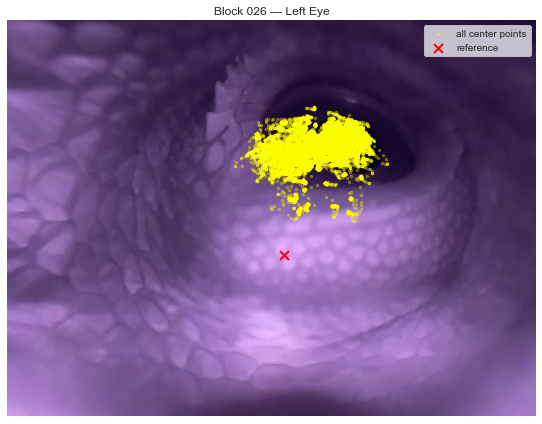

In [9]:
# verification here: 
# first, I want to see the data superimposed on a single block's eye frames as it is now
import cv2
import numpy as np
import matplotlib.pyplot as plt

def show_first_frame_with_reference(block, eye, apply_rotation=True, xflip=True):
    """
    For the given BlockSync instance and eye ('left' or 'right'), loads the first video frame,
    optionally flips & rotates it to match your data basis, and then overlays:
      • all center_x, center_y points (yellow dots, semi-transparent)
      • the best reference point (large red 'X')
    """
    # pick the right attributes
    if eye == 'left':
        video_path = block.le_videos[0]
        df = block.left_eye_data
        M = block.left_rotation_matrix
        ref_x = block.kerr_ref_l_x
        ref_y = block.kerr_ref_l_y
        print(ref_x,ref_y)
    elif eye == 'right':
        print('hi')
        video_path = block.re_videos[0]
        df = block.right_eye_data
        M = block.right_rotation_matrix
        ref_x = block.kerr_ref_r_x
        ref_y = block.kerr_ref_r_y
        print(ref_x,ref_y)
    else:
        raise ValueError("eye must be 'left' or 'right'")

    # read first frame
    cap = cv2.VideoCapture(str(video_path))
    ret, frame = cap.read()
    cap.release()
    if not ret:
        print(f"⚠️  Could not read first frame of {eye} eye video at {video_path}")
        return

    # flip if needed
    if xflip:
        frame = cv2.flip(frame, 1)

    # apply your rotation matrix if you want the same basis as the data
    if apply_rotation and (M is not None):
        frame = cv2.warpAffine(frame, M, (frame.shape[1], frame.shape[0]))

    # compute “best reference” exactly as BlockSync.get_best_reference does
    if {'major_ax','minor_ax'}.issubset(df.columns):
        ratio = df['major_ax'] / df['minor_ax']
        anchor_idx = np.argmin(np.abs(ratio - 1))
    else:
        # fallback to midpoint of your measured centers
        anchor_idx = len(df) // 2

    # ref_x = df['center_x'].iloc[anchor_idx]
    # ref_y = df['center_y'].iloc[anchor_idx]

    # plot
    fig, ax = plt.subplots(figsize=(8,6))
    ax.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    ax.scatter(df['center_x'], df['center_y'],
               s=6, c='yellow', alpha=0.3, label='all center points')
    ax.scatter([ref_x], [ref_y],
               s=80, c='red', marker='x', lw=2, label='reference')
    ax.set_title(f"Block {block.block_num} — {eye.title()} Eye")
    ax.set_xlim(0, frame.shape[1])
    ax.set_ylim(frame.shape[0], 0)          # invert y to match image coords
    ax.axis('off')
    ax.legend(loc='upper right')
    plt.tight_layout()
    plt.show()


# === usage: right before your final export cell ===
# for block in block_collection:
#     show_first_frame_with_reference(block, 'left',  apply_rotation=True, xflip=True)
#     show_first_frame_with_reference(block, 'right', apply_rotation=True, xflip=True)

block = block_collection[2]
block.load_best_reference(r'Z:\Nimrod\experiments\cross_animals_data\kerr_reference_all_animals.csv')
show_first_frame_with_reference(block,'left',apply_rotation=False,xflip=True)

In [5]:
block.load_best_reference(r'Z:\Nimrod\experiments\cross_animals_data\kerr_reference_all_animals.csv')
block.calculate_kerr_angles(name_tag='raw')

found reference file and loaded points
working on Block 013
Left eye
Left eye


C:\Users\MarkS3\PycharmProjects\pythonProject3\BlockSync_current.py:2999: RuntimeWarning: invalid value encountered in arcsin
  comp_t = np.arcsin((bPC_values[valid_positions] - bEC) / (np.cos(comp_p) * f_z))


finished successfully and saved to Z:\Nimrod\experiments\PV_57\2024_12_01\block_013\analysis with tag= raw


In [3]:
print(ref_points)

   eye  animal  block     x0     y0
0    R     126     13  416.0  251.0
1    L     126     13  282.0  233.0
2    L     126     12  344.0  325.0
3    R     126     12  335.0  313.0
4    R     126     11  307.0  321.0
5    L     126     11  396.0  335.0
6    L     126     10  351.0  341.0
7    R     126     10  323.0  313.0
8    R     126      9  335.0  335.0
9    L     126      9  360.0  343.0
10   L      62     23  365.0  361.0
11   R      62     23    NaN    NaN
12   R      62     38  470.0  346.0
13   L      62     38  320.0  307.0
14   L      62     26  335.0  284.0
15   R      62     26  404.0  312.0
16   R      62     24  439.0  355.0
17   L      62     24  332.0  280.0
18   L      57      7  359.0  384.0
19   R      57      7  310.0  403.0
20   R      57      8  325.0  430.0
21   L      57      8  366.0  349.0
22   L      57      9  375.0  368.0
23   R      57      9  312.0  430.0
24   R      57     11  343.0  413.0
25   L      57     11  332.0  354.0
26   L      57     12  341.0

In [15]:
import numbers
def find_roundest_ellipse_in_df(df):
    s = df.ratio2
    closest_ind = np.nanargmin(np.abs(s - 1))  # find the index of the value closest to 1
    return int(closest_ind)

def kerr(df, aEC = np.nan, bEC = np.nan):
    if aEC != aEC:
        idx = find_roundest_ellipse_in_df(df)
        dx = df.loc[df.index[idx],'center_x']
        dy = df.loc[df.index[idx],'center_y']
        if not isinstance(dx, numbers.Number):
            dx = dx.iloc[0]
        if not isinstance(dy, numbers.Number):
            dy = dy.iloc[0]
        aEC = int(dx)
        bEC = int(dy)

    theta_values = np.full(len(df), np.nan)  # Initialize theta column with NaNs
    phi_values = np.full(len(df), np.nan)  # Initialize phi column with NaNs
    r_values = np.full(len(df), np.nan)  # Initialize r column with NaNs

    # Convert columns to NumPy arrays for faster access
    hw_values = df['ratio2'].values
    aPC_values = df['center_x'].values
    bPC_values = df['center_y'].values

    # Mask for valid `hw` values (to ignore NaNs)
    valid_mask = ~np.isnan(hw_values)

    # Vectorized computation for `top` and `bot`
    sqrt_component = np.sqrt(1 - hw_values[valid_mask]**2)
    distances = np.sqrt((aPC_values[valid_mask] - aEC)**2 + (bPC_values[valid_mask] - bEC)**2)

    top_values = sqrt_component * distances
    bot_values = (1 - hw_values[valid_mask]**2)

    top = np.sum(top_values)
    bot = np.sum(bot_values)

    f_z = top / bot

    # Compute `r` for all rows where `major_ax` is valid
    valid_major_ax = ~np.isnan(df['major_ax'].values)
    max_axes = np.maximum(df['major_ax'].values, df['minor_ax'].values)
    r_values[valid_major_ax]  = (2 * max_axes[valid_major_ax]) / f_z

    # Compute `theta` and `phi` in a vectorized way
    valid_positions = ~np.isnan(aPC_values) & ~np.isnan(bPC_values)

    # p1 = (aPC_values[valid_positions] - aEC)
    # p = p1/f_z
    comp_p = np.arcsin((aPC_values[valid_positions] - aEC) / f_z)

    # t1 = (bPC_values[valid_positions] - bEC)
    # t2 =  (np.cos(comp_p) * f_z)
    # t = t1/t2
    comp_t = np.arcsin((bPC_values[valid_positions] - bEC) / (np.cos(comp_p) * f_z))

    theta_values[valid_positions] = np.degrees(comp_t)
    phi_values[valid_positions] = np.degrees(comp_p)

    # Create output DataFrame
    output_df = pd.DataFrame({'r': r_values, 'theta': theta_values, 'phi': phi_values}, index=df.index)
    output_df = pd.concat([df[['OE_timestamp', 'eye_frame', 'ms_axis']],output_df], axis=1)
    return f_z, output_df #, valid_mask, valid_major_ax, valid_positions

In [16]:


def kerr_block2(block,ref_points, name_tag='0'):
    time = datetime.datetime.now()
    print(f'working on Block {block.block_num}')
    print('Left eye')

    df = block.left_eye_data
    df['ratio2'] = df.minor_ax / df.major_ax
    df['phi_ellipse'] = df.phi
    try:
        ref_row = ref_points[(ref_points.eye == 'L') & (ref_points.animal == int(block.animal_call.replace('PV_',''))) & (ref_points.block == int(block.block_num))]
        aEC, bEC = ref_row.x0.iloc[0] , ref_row.y0.iloc[0]
    except:
        idx = find_roundest_ellipse_in_df(df)
        dx = df.loc[df.index[idx],'center_x']
        dy = df.loc[df.index[idx],'center_y']
        if not isinstance(dx, numbers.Number):
            dx = dx.iloc[0]
        if not isinstance(dy, numbers.Number):
            dy = dy.iloc[0]
        aEC = int(dx)
        bEC = int(dy)
    f_z, output_df_l = kerr(df, aEC=aEC, bEC=bEC)
    

   

    print('Right eye')
    df = block.right_eye_data
    df['ratio2'] = df.minor_ax / df.major_ax
    df['phi_ellipse'] = df.phi
    
    try:
        ref_row = ref_points[(ref_points.eye == 'R') & (ref_points.animal == int(block.animal_call.replace('PV_',''))) & (ref_points.block == int(block.block_num))]
        aEC, bEC = ref_row.x0.iloc[0] , ref_row.y0.iloc[0]
    except:
        idx = find_roundest_ellipse_in_df(df)
        dx = df.loc[df.index[idx],'center_x']
        dy = df.loc[df.index[idx],'center_y']
        if not isinstance(dx, numbers.Number):
            dx = dx.iloc[0]
        if not isinstance(dy, numbers.Number):
            dy = dy.iloc[0]
        aEC = int(dx)
        bEC = int(dy)
    f_z, output_df_r = kerr(df, aEC=aEC, bEC=bEC)


    block.left_eye_kerr_ang = output_df_l
    block.left_eye_kerr_ang.to_csv(block.analysis_path / f'left_kerr_angle_{name_tag}.csv')
    
    block.right_eye_kerr_ang = output_df_r
    block.right_eye_kerr_ang.to_csv(block.analysis_path / f'right_kerr_angle_{name_tag}.csv')
    print(f'finished successfully and saved to {block.analysis_path} with tag= {name_tag}')

In [17]:
name_tag = 'raw'
for block in block_collection: 
    kerr_block2(block,ref_points=ref_points,name_tag=name_tag)

working on Block 023
Left eye
Right eye


<ipython-input-15-782ed0846318>:58: RuntimeWarning: invalid value encountered in arcsin
  comp_t = np.arcsin((bPC_values[valid_positions] - bEC) / (np.cos(comp_p) * f_z))


finished successfully and saved to Z:\Nimrod\experiments\PV_62\2023_04_27\block_023\analysis with tag= raw
working on Block 024
Left eye
Right eye


<ipython-input-15-782ed0846318>:58: RuntimeWarning: invalid value encountered in arcsin
  comp_t = np.arcsin((bPC_values[valid_positions] - bEC) / (np.cos(comp_p) * f_z))


finished successfully and saved to Z:\Nimrod\experiments\PV_62\2023_04_27\block_024\analysis with tag= raw
working on Block 026
Left eye
Right eye


<ipython-input-15-782ed0846318>:58: RuntimeWarning: invalid value encountered in arcsin
  comp_t = np.arcsin((bPC_values[valid_positions] - bEC) / (np.cos(comp_p) * f_z))


finished successfully and saved to Z:\Nimrod\experiments\PV_62\2023_04_27\block_026\analysis with tag= raw
working on Block 038
Left eye
Right eye


<ipython-input-15-782ed0846318>:58: RuntimeWarning: invalid value encountered in arcsin
  comp_t = np.arcsin((bPC_values[valid_positions] - bEC) / (np.cos(comp_p) * f_z))
<ipython-input-15-782ed0846318>:53: RuntimeWarning: invalid value encountered in arcsin
  comp_p = np.arcsin((aPC_values[valid_positions] - aEC) / f_z)
<ipython-input-15-782ed0846318>:58: RuntimeWarning: invalid value encountered in arcsin
  comp_t = np.arcsin((bPC_values[valid_positions] - bEC) / (np.cos(comp_p) * f_z))


finished successfully and saved to Z:\Nimrod\experiments\PV_62\2023_05_01\block_038\analysis with tag= raw
working on Block 007
Left eye
Right eye


<ipython-input-15-782ed0846318>:53: RuntimeWarning: invalid value encountered in arcsin
  comp_p = np.arcsin((aPC_values[valid_positions] - aEC) / f_z)
<ipython-input-15-782ed0846318>:58: RuntimeWarning: invalid value encountered in arcsin
  comp_t = np.arcsin((bPC_values[valid_positions] - bEC) / (np.cos(comp_p) * f_z))
<ipython-input-15-782ed0846318>:58: RuntimeWarning: invalid value encountered in arcsin
  comp_t = np.arcsin((bPC_values[valid_positions] - bEC) / (np.cos(comp_p) * f_z))


finished successfully and saved to Z:\Nimrod\experiments\PV_126\2024_07_18\block_007\analysis with tag= raw
working on Block 008
Left eye
Right eye


<ipython-input-15-782ed0846318>:53: RuntimeWarning: invalid value encountered in arcsin
  comp_p = np.arcsin((aPC_values[valid_positions] - aEC) / f_z)
<ipython-input-15-782ed0846318>:58: RuntimeWarning: invalid value encountered in arcsin
  comp_t = np.arcsin((bPC_values[valid_positions] - bEC) / (np.cos(comp_p) * f_z))


finished successfully and saved to Z:\Nimrod\experiments\PV_126\2024_07_18\block_008\analysis with tag= raw
working on Block 009
Left eye
Right eye


<ipython-input-15-782ed0846318>:58: RuntimeWarning: invalid value encountered in arcsin
  comp_t = np.arcsin((bPC_values[valid_positions] - bEC) / (np.cos(comp_p) * f_z))


finished successfully and saved to Z:\Nimrod\experiments\PV_126\2024_07_18\block_009\analysis with tag= raw
working on Block 010
Left eye
Right eye


<ipython-input-15-782ed0846318>:58: RuntimeWarning: invalid value encountered in arcsin
  comp_t = np.arcsin((bPC_values[valid_positions] - bEC) / (np.cos(comp_p) * f_z))
<ipython-input-15-782ed0846318>:58: RuntimeWarning: invalid value encountered in arcsin
  comp_t = np.arcsin((bPC_values[valid_positions] - bEC) / (np.cos(comp_p) * f_z))


finished successfully and saved to Z:\Nimrod\experiments\PV_126\2024_07_18\block_010\analysis with tag= raw
working on Block 011
Left eye
Right eye


<ipython-input-15-782ed0846318>:58: RuntimeWarning: invalid value encountered in arcsin
  comp_t = np.arcsin((bPC_values[valid_positions] - bEC) / (np.cos(comp_p) * f_z))


finished successfully and saved to Z:\Nimrod\experiments\PV_126\2024_08_13\block_011\analysis with tag= raw
working on Block 012
Left eye
Right eye
finished successfully and saved to Z:\Nimrod\experiments\PV_126\2024_08_13\block_012\analysis with tag= raw
working on Block 007
Left eye
Right eye
finished successfully and saved to Z:\Nimrod\experiments\PV_57\2024_11_25\block_007\analysis with tag= raw
working on Block 008
Left eye
Right eye


<ipython-input-15-782ed0846318>:58: RuntimeWarning: invalid value encountered in arcsin
  comp_t = np.arcsin((bPC_values[valid_positions] - bEC) / (np.cos(comp_p) * f_z))


finished successfully and saved to Z:\Nimrod\experiments\PV_57\2024_11_25\block_008\analysis with tag= raw
working on Block 009
Left eye
Right eye


<ipython-input-15-782ed0846318>:58: RuntimeWarning: invalid value encountered in arcsin
  comp_t = np.arcsin((bPC_values[valid_positions] - bEC) / (np.cos(comp_p) * f_z))


finished successfully and saved to Z:\Nimrod\experiments\PV_57\2024_11_25\block_009\analysis with tag= raw
working on Block 011
Left eye
Right eye


<ipython-input-15-782ed0846318>:58: RuntimeWarning: invalid value encountered in arcsin
  comp_t = np.arcsin((bPC_values[valid_positions] - bEC) / (np.cos(comp_p) * f_z))


finished successfully and saved to Z:\Nimrod\experiments\PV_57\2024_12_01\block_011\analysis with tag= raw
working on Block 012
Left eye
Right eye


<ipython-input-15-782ed0846318>:58: RuntimeWarning: invalid value encountered in arcsin
  comp_t = np.arcsin((bPC_values[valid_positions] - bEC) / (np.cos(comp_p) * f_z))


finished successfully and saved to Z:\Nimrod\experiments\PV_57\2024_12_01\block_012\analysis with tag= raw
working on Block 013
Left eye
Right eye


<ipython-input-15-782ed0846318>:58: RuntimeWarning: invalid value encountered in arcsin
  comp_t = np.arcsin((bPC_values[valid_positions] - bEC) / (np.cos(comp_p) * f_z))


finished successfully and saved to Z:\Nimrod\experiments\PV_57\2024_12_01\block_013\analysis with tag= raw


In [5]:
for block in block_collection:
    block.left_eye_data = pd.read_csv(block.analysis_path / 'left_eye_data_original.csv')
    block.right_eye_data = pd.read_csv(block.analysis_path / 'right_eye_data_original.csv')
    

In [60]:
for block in block_collection:
    print(block)
    print([i.name for i in block.analysis_path.iterdir() if 'raw' in str(i)])

PV_62, block 023, on 2023-04-27_10-52-42
['left_eye_data_degrees_raw.csv', 'left_kerr_angle_raw.csv', 'right_eye_data_degrees_raw.csv', 'right_kerr_angle_raw.csv']
PV_62, block 024, on 2023-04-27_11-22-56
['left_eye_data_degrees_raw.csv', 'left_kerr_angle_raw.csv', 'right_eye_data_degrees_raw.csv', 'right_kerr_angle_raw.csv']
PV_62, block 026, on 2023-04-27_12-21-41
['left_eye_data_degrees_raw.csv', 'left_kerr_angle_raw.csv', 'right_eye_data_degrees_raw.csv', 'right_kerr_angle_raw.csv']
PV_62, block 038, on 2023-05-01_13-57-45
['left_eye_data_degrees_raw.csv', 'left_kerr_angle_raw.csv', 'right_eye_data_degrees_raw.csv', 'right_kerr_angle_raw.csv']
PV_126, block 007, on PV126_Trial16_wake3_2024-07-18_12-49-12
['left_eye_data_degrees_raw.csv', 'left_kerr_angle_raw.csv', 'right_eye_data_degrees_raw.csv', 'right_kerr_angle_raw.csv']
PV_126, block 008, on PV126_Trial16_wake4_2024-07-18_13-24-41
['left_eye_data_degrees_raw.csv', 'left_kerr_angle_raw.csv', 'right_eye_data_degrees_raw.csv', 'r

In [18]:
# load and combine the eye data with the angle calculation
def append_angle_data(eye_df, new_df):
    """
    Appends the angle columns (phi and theta) from new_df to eye_df.
    The function renames 'phi' to 'k_phi' and 'theta' to 'k_theta', then merges
    on the shared 'OE_timestamp' column.
    
    Parameters:
    - eye_df: pandas DataFrame containing the eye tracking data.
    - new_df: pandas DataFrame containing the new kinematics data with columns
              'phi' and 'theta' along with 'OE_timestamp' (and possibly others).
    
    Returns:
    - merged_df: pandas DataFrame resulting from merging the new kinematics data
                 into eye_df.
    """
    # Select the necessary columns and rename them
    angle_data = new_df[['OE_timestamp', 'phi', 'theta']].rename(
        columns={'phi': 'k_phi', 'theta': 'k_theta'}
    )
    
    # Merge on OE_timestamp using a left join to preserve all rows in eye_df
    merged_df = pd.merge(eye_df, angle_data, on='OE_timestamp', how='left')
    
    return merged_df
for block in block_collection:
    print(block)
    try:
        left_angles = pd.read_csv([i for i in block.analysis_path.iterdir() if (f'left_kerr_angle_{name_tag}.csv' in str(i))][0])
        right_angles = pd.read_csv([i for i in block.analysis_path.iterdir() if (f'right_kerr_angle_{name_tag}.csv' in str(i))][0])
    except IndexError:
        print(f'{block} has a problem, files missing')
        
    block.left_eye_data = append_angle_data(block.left_eye_data,left_angles)
    block.right_eye_data = append_angle_data(block.right_eye_data,right_angles)



PV_62, block 023, on 2023-04-27_10-52-42
PV_62, block 024, on 2023-04-27_11-22-56
PV_62, block 026, on 2023-04-27_12-21-41
PV_62, block 038, on 2023-05-01_13-57-45
PV_126, block 007, on PV126_Trial16_wake3_2024-07-18_12-49-12
PV_126, block 008, on PV126_Trial16_wake4_2024-07-18_13-24-41
PV_126, block 009, on PV126_Trial18_wake5_2024-07-18_14-39-15
PV_126, block 010, on PV126_Trial19_wake6_2024-07-18_15-24-57
PV_126, block 011, on PV126_Trial115_eyeTracking_w7
PV_126, block 012, on PV126_Trial116_eyeTracking_h8
PV_57, block 007, on pv_57_day2_03_2024-11-25_15-28-31
PV_57, block 008, on pv_57_day2_05_2024-11-25_16-07-18
PV_57, block 009, on pv_57_day2_06_2024-11-25_16-25-35
PV_57, block 011, on PV_57_hunter_2_2024-12-01_15-43-28
PV_57, block 012, on PV_57_hunter_2_2024-12-01_16-08-39
PV_57, block 013, on PV_57_hunter_2_2024-12-01_16-34-43


In [19]:
def export_eye_data_w_angles(block, name_tag='0'):
    block.right_eye_data.to_csv(block.analysis_path / f'right_eye_data_{name_tag}.csv')
    block.left_eye_data.to_csv(block.analysis_path / f'left_eye_data_{name_tag}.csv')
for block in block_collection:
    export_eye_data_w_angles(block, name_tag='degrees_raw')

In [28]:
import numpy as np
import pandas as pd
import json

def load_rotation_matrix(filepath):
    """Load a 3x3 rotation matrix (stored in JSON) as a NumPy array."""
    with open(filepath, "r") as f:
        matrix = json.load(f)
    return np.array(matrix)

def angles_to_vectors(phis, thetas):
    """
    Vectorized conversion of gaze angles (in degrees) to 3D unit vectors.
    Assumes:
      - phis: azimuth angles (degrees)
      - thetas: elevation angles (degrees)
    Conversion (using spherical coordinates):
      x = cos(theta) * cos(phi)
      y = cos(theta) * sin(phi)
      z = sin(theta)
    """
    # Convert degrees to radians.
    p = np.deg2rad(phis)
    t = np.deg2rad(thetas)
    x = np.cos(t) * np.cos(p)
    y = np.cos(t) * np.sin(p)
    z = np.sin(t)
    return np.column_stack((x, y, z))  # (n, 3) array

def vectors_to_angles(vectors):
    """
    Vectorized conversion of 3D vectors to gaze angles (in degrees).
    Returns:
      - phis: azimuth angles computed via arctan2(y, x)
      - thetas: elevation angles computed via arcsin(z/norm)
    """
    x = vectors[:, 0]
    y = vectors[:, 1]
    z = vectors[:, 2]
    phis = np.rad2deg(np.arctan2(y, x))
    norms = np.linalg.norm(vectors, axis=1)
    # Clip the ratio for numerical stability.
    thetas = np.rad2deg(np.arcsin(np.clip(z / norms, -1.0, 1.0)))
    return phis, thetas

def correct_gaze_angles_vectorized(df, rot_matrix):
    """
    Correct gaze angles in a dataframe using the composite rotation matrix.
    This function:
      1. Converts all (k_phi, k_theta) values to 3D vectors.
      2. Applies the rotation to all vectors at once.
      3. Converts the rotated vectors back into (k_phi, k_theta).
    Returns:
      Two NumPy arrays: corrected azimuths and elevations.
    """
    # Extract arrays of angles.
    phis = df["k_phi"].values
    thetas = df["k_theta"].values
    # Convert to 3D vectors.
    vectors = angles_to_vectors(phis, thetas)
    # Apply rotation; note: using the transpose so that each row is rotated.
    vectors_corr = np.dot(vectors, rot_matrix.T)
    # Convert corrected vectors back to angles.
    k_phi_corr, k_theta_corr = vectors_to_angles(vectors_corr)
    return k_phi_corr, k_theta_corr

def correct_block_sync_data(block, left_json_path, right_json_path):
    """
    Correct the eye tracking angles stored in block.left_eye_data and block.right_eye_data.
    
    Parameters:
      block           : Object with attributes left_eye_data and right_eye_data (Pandas dataframes).
      left_json_path  : Path to the JSON file storing the left eye 3x3 rotation matrix.
      right_json_path : Path to the JSON file storing the right eye 3x3 rotation matrix.
    
    Process:
      1. Load the rotation matrices from the provided JSON files.
      2. Convert the raw angles in left/right eye dataframes from (k_phi, k_theta) into 3D unit vectors.
      3. Apply the composite rotation to bring them into the common anatomical frame.
      4. Convert the rotated vectors back into (k_phi, k_theta).
      5. Append the corrected angles as new columns ("k_phi_corr" and "k_theta_corr").
    
    Returns:
      (corrected_left_eye_data, corrected_right_eye_data)
      where each is a Pandas dataframe containing both the original and corrected angles.
    """
    # Load rotation matrices.
    rot_matrix_left = load_rotation_matrix(left_json_path)
    rot_matrix_right = load_rotation_matrix(right_json_path)
    
    # Process left eye dataframe.
    left_df = block.left_eye_data.copy()
    left_phi_corr, left_theta_corr = correct_gaze_angles_vectorized(left_df, rot_matrix_left)
    left_df["k_phi_corr"] = left_phi_corr
    left_df["k_theta_corr"] = left_theta_corr
    
    # Process right eye dataframe.
    right_df = block.right_eye_data.copy()
    right_phi_corr, right_theta_corr = correct_gaze_angles_vectorized(right_df, rot_matrix_right)
    right_df["k_phi_corr"] = right_phi_corr
    right_df["k_theta_corr"] = right_theta_corr
    
    # Return the corrected dataframes for inspection.
    return left_df, right_df



In [3]:
block_dict.keys()

dict_keys(['PV_62_block_023', 'PV_62_block_024', 'PV_62_block_026', 'PV_62_block_038', 'PV_126_block_007', 'PV_126_block_008', 'PV_126_block_009', 'PV_126_block_010', 'PV_126_block_011', 'PV_126_block_012', 'PV_57_block_007', 'PV_57_block_008', 'PV_57_block_009', 'PV_57_block_011', 'PV_57_block_012', 'PV_57_block_013'])

# This is the new version of what happens below

In [59]:
import json
import numpy as np
import plotly.graph_objects as go

# -----------------------------------------------------------------------------
def load_rotation_matrix(path):
    """Load 3×3 rotation matrix (JSON) into an ndarray."""
    return np.array(json.load(open(path,'r')))

def angles_to_vecs(phis, thetas):
    """(N,) arrays → Nx3 unit vectors."""
    p = np.deg2rad(phis); t = np.deg2rad(thetas)
    x = np.cos(t)*np.cos(p)
    y = np.cos(t)*np.sin(p)
    z = np.sin(t)
    return np.vstack((x,y,z)).T

def vecs_to_angles(v):
    """Nx3 vector array → (phis, thetas) in degrees."""
    x,y,z = v[:,0], v[:,1], v[:,2]
    phis  = np.rad2deg(np.arctan2(y,x))
    thetas= np.rad2deg(np.arcsin(np.clip(z, -1.0, 1.0)))
    return phis, thetas

def correct_eye_df(df, json_path):
    """
    Correct a single eye DataFrame with columns k_phi,k_theta.
    If flip_x is True (e.g. left eye post‑processing), flips horizontal sign.
    """
    R   = load_rotation_matrix(json_path)    # use R directly (no .T!)
    V   = angles_to_vecs(df.k_phi.values, df.k_theta.values)
    # phi0, theta0 = 0.0, 0.0
    # V_test = angles_to_vecs(np.array([phi0]), np.array([theta0]))
    
    #np.insert(V, 0, [1,0,0], axis=0)
    V[0] = [.1,.0,.0]
    Vc  = V @ R                               # image→anatomy
    df2 = df.copy()
    df2['k_phi_corr'], df2['k_theta_corr'] = vecs_to_angles(Vc)
    return df2

def visualize_correction_subset(df, subset=30, title="Eye: Orig vs Corr"):
    """Interactive Plotly sphere of original vs corrected vectors."""
    V_o = angles_to_vecs(df.k_phi.values, df.k_theta.values)
    V_c = angles_to_vecs(df.k_phi_corr.values, df.k_theta_corr.values)
    idx = np.linspace(0, len(df)-1, min(subset,len(df))).astype(int)
    idx[0] = 0
    # sphere
    u = np.linspace(0,2*np.pi,60); v = np.linspace(0,np.pi,30)
    uu,vv = np.meshgrid(u,v)
    xs = np.cos(uu)*np.sin(vv); ys = np.sin(uu)*np.sin(vv); zs = np.cos(vv)

    fig = go.Figure()
    fig.add_trace(go.Surface(
        x=xs, y=ys, z=zs, opacity=0.2, showscale=False,
        colorscale=[[0,'lightgray'],[1,'lightgray']],
    ))
    for i in idx:
        xo,yo,zo = V_o[i]; xc,yc,zc = V_c[i]
        fig.add_trace(go.Scatter3d(
            x=[xo], y=[yo], z=[zo],
            mode='markers', marker=dict(size=4,color='blue'),
            name='Orig' if i==idx[0] else None
        ))
        fig.add_trace(go.Scatter3d(
            x=[xc], y=[yc], z=[zc],
            mode='markers', marker=dict(size=4,color='red'),
            name='Corr' if i==idx[0] else None
        ))
        fig.add_trace(go.Scatter3d(
            x=[xo,xc], y=[yo,yc], z=[zo,zc],
            mode='lines', line=dict(color='gray',width=2),
            showlegend=False
        ))

    fig.update_layout(
        title=title,
        scene=dict(
          aspectmode='cube',
          xaxis=dict(title='X',range=[-1,1]),
          yaxis=dict(title='Y',range=[-1,1]),
          zaxis=dict(title='Z',range=[-1,1]),
        )
    )
    fig.show()

# ------------------------------------------------------------------------------

# assuming `block` already has left_eye_data / right_eye_data loaded
blender_project_path = pathlib.Path(r"D:\MarkS3\Documents\BlenderFiles\Camera_angle_registration\PV_57_textured-20250325T102628Z-001")
left_json_path = blender_project_path / "l_rot_matrix_v8.json"
right_json_path = blender_project_path / "r_rot_matrix_v8.json"
left_df  = correct_eye_df(block.left_eye_data,  left_json_path)
right_df = correct_eye_df(block.right_eye_data, right_json_path)

visualize_correction_subset(left_df, subset=100, title='left')
visualize_correction_subset(right_df, subset=100, title='right')


In [42]:
def visualize_correction_with_zero(df, R, subset=30, eye='Eye'):
    """
    Interactive Plotly 3D sphere showing:
      - Original gaze (blue)
      - Corrected gaze (red)
      - Old zero‑gaze arrow (green)
      - New zero‑gaze arrow (magenta)
    """
    import numpy as np
    import plotly.graph_objects as go

    # Sphere mesh
    u = np.linspace(0,2*np.pi,60)
    v = np.linspace(0,np.pi,30)
    uu,vv = np.meshgrid(u,v)
    xs = np.cos(uu)*np.sin(vv)
    ys = np.sin(uu)*np.sin(vv)
    zs = np.cos(vv)

    # Gaze vectors
    V_o = angles_to_vecs(df.k_phi.values, df.k_theta.values)
    V_c = angles_to_vecs(df.k_phi_corr.values, df.k_theta_corr.values)
    idx = np.linspace(0,len(df)-1,min(subset,len(df))).astype(int)

    # Zero‑gaze arrows
    orig_zero = np.array([1.0, 0.0, 0.0])
    corr_zero = orig_zero @ R

    fig = go.Figure()

    # Eyeball
    fig.add_trace(go.Surface(
        x=xs, y=ys, z=zs, opacity=0.2, showscale=False,
        colorscale=[[0,'lightgray'],[1,'lightgray']]
    ))

    # Zero‑gaze helpers
    fig.add_trace(go.Scatter3d(
        x=[0, orig_zero[0]], y=[0, orig_zero[1]], z=[0, orig_zero[2]],
        mode='lines+markers',
        line=dict(color='green', width=6),
        marker=dict(size=4, color='green'),
        name='Orig zero',
        showlegend=True
    ))
    fig.add_trace(go.Scatter3d(
        x=[0, corr_zero[0]], y=[0, corr_zero[1]], z=[0, corr_zero[2]],
        mode='lines+markers',
        line=dict(color='magenta', width=6),
        marker=dict(size=4, color='magenta'),
        name='Corr zero',
        showlegend=True
    ))

    # Plot gaze points & connectors
    first = True
    for i in idx:
        xo,yo,zo = V_o[i]
        xc,yc,zc = V_c[i]
        # original gaze
        fig.add_trace(go.Scatter3d(
            x=[xo], y=[yo], z=[zo],
            mode='markers',
            marker=dict(size=3, color='blue'),
            name='Orig gaze' if first else None,
            showlegend=bool(first)
        ))
        # corrected gaze
        fig.add_trace(go.Scatter3d(
            x=[xc], y=[yc], z=[zc],
            mode='markers',
            marker=dict(size=3, color='red'),
            name='Corr gaze' if first else None,
            showlegend=False
        ))
        # connector
        fig.add_trace(go.Scatter3d(
            x=[xo, xc], y=[yo, yc], z=[zo, zc],
            mode='lines', line=dict(color='gray', width=1),
            showlegend=False
        ))
        first = False

    fig.update_layout(
        title=f"{eye} Eye: Orig vs Corr + Zero‑Gaze Helpers",
        scene=dict(
            aspectmode='cube',
            xaxis=dict(title='X', range=[-1,1]),
            yaxis=dict(title='Y', range=[-1,1]),
            zaxis=dict(title='Z', range=[-1,1]),
        )
    )
    fig.show()


In [43]:
# Load your R matrix as before, e.g.:
R_left = load_rotation_matrix(left_json_path)
R_right = load_rotation_matrix(right_json_path)

# Correct your DataFrame:
left_df = correct_eye_df(block.left_eye_data, left_json_path)

# Then visualize with zero helpers:
visualize_correction_with_zero(left_df, R_left, subset=100, eye='Left')


# from here, There's an attempt to read and use the rotation matrices created in blender to correct the angles into an anatomically reasonable frame of reference. This is the older version:  

In [44]:
visualize_correction_with_zero(right_df, R_right, subset=100, eye='Right')

In [39]:
print(R_left)

[[ 0.95419568  0.16977711  0.24634624]
 [-0.09801041  0.95534307 -0.27877149]
 [-0.28267416  0.24185805  0.92822415]]


In [40]:
print(R_right)

[[ 0.91591716 -0.19419399 -0.35126144]
 [ 0.06733017  0.93709892 -0.34250885]
 [ 0.39567983  0.29005921  0.87138003]]


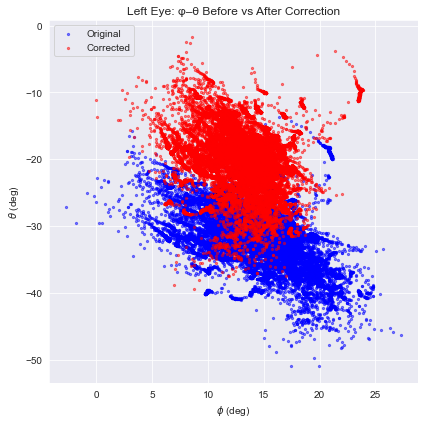

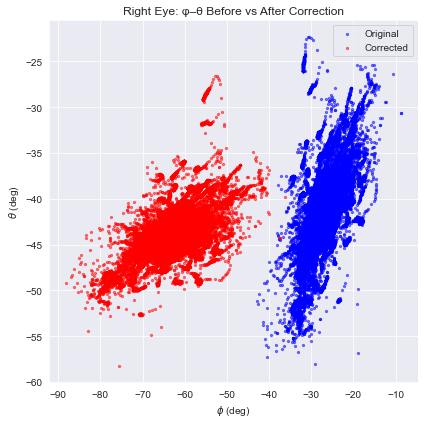

In [35]:
def plot_phi_theta_comparison(df, eye='left'):
    """
    Scatter plot of (k_phi, k_theta) before and after correction.
    
    Parameters:
      df  : DataFrame with 'k_phi','k_theta','k_phi_corr','k_theta_corr'
      eye : 'left' or 'right' (for title)
    """
    phi_orig   = df['k_phi']
    theta_orig = df['k_theta']
    phi_corr   = df['k_phi_corr']
    theta_corr = df['k_theta_corr']
    
    plt.figure(figsize=(6,6))
    plt.scatter(phi_orig, theta_orig, 
                s=5, alpha=0.5, label='Original', c='blue')
    plt.scatter(phi_corr, theta_corr, 
                s=5, alpha=0.5, label='Corrected', c='red')
    plt.xlabel(r'$\phi$ (deg)')
    plt.ylabel(r'$\theta$ (deg)')
    plt.title(f'{eye.capitalize()} Eye: φ–θ Before vs After Correction')
    plt.legend(loc='best')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Example usage:
plot_phi_theta_comparison(left_df, eye='left')
plot_phi_theta_comparison(right_df, eye='right')

In [22]:
block = block_dict['PV_57_block_008']
block.left_eye_data = pd.read_csv(block.analysis_path / 'left_eye_data_degrees_raw.csv')
block.right_eye_data = pd.read_csv(block.analysis_path / 'right_eye_data_degrees_raw.csv')


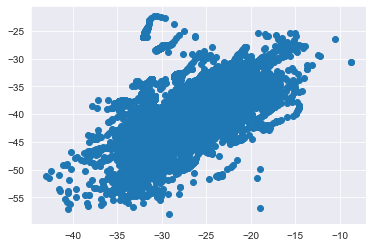

In [36]:
k_phi = block.right_eye_data['k_phi']
k_theta = block.right_eye_data['k_theta']
plt.scatter(k_phi,k_theta)

In [37]:
k_phi = block.right_eye_data['k_phi_corr']
k_theta = block.right_eye_data['k_theta_corr']
plt.scatter(k_phi,k_theta)

KeyError: 'k_phi_corr'

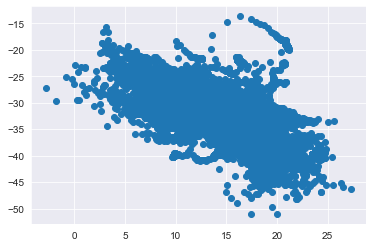

In [25]:
k_phi = block.left_eye_data['k_phi']
k_theta = block.left_eye_data['k_theta']
plt.scatter(k_phi,k_theta)

In [53]:
import numpy as np
import pandas as pd

def load_rotation_matrix(path):
    """Load a 3×3 rotation matrix from JSON into a NumPy array."""
    with open(path, 'r') as f:
        mat = json.load(f)
    return np.array(mat)


def angles_to_vecs(phis, thetas):
    """Convert arrays of azimuth (phis) and elevation (thetas) in degrees to 3D unit vectors."""
    p = np.deg2rad(phis)
    t = np.deg2rad(thetas)
    x = np.cos(t) * np.cos(p)
    y = np.cos(t) * np.sin(p)
    z = np.sin(t)
    return np.vstack((x, y, z)).T


def vecs_to_angles(vecs):
    """Convert 3D unit vectors to azimuth (phis) and elevation (thetas) in degrees."""
    x, y, z = vecs[:,0], vecs[:,1], vecs[:,2]
    phis = np.rad2deg(np.arctan2(y, x))
    norms = np.linalg.norm(vecs, axis=1)
    thetas = np.rad2deg(np.arcsin(np.clip(z / norms, -1.0, 1.0)))
    return phis, thetas


def correct_block_sync_data(block, left_json_path, right_json_path):
    """
    Correct the gaze angles in block.left_eye_data and block.right_eye_data
    using the rotation matrices exported from Blender.

    Parameters:
      block           : object with attributes left_eye_data and right_eye_data (Pandas DataFrames).
      left_json_path  : file path to left eye rotation JSON (3×3 matrix).
      right_json_path : file path to right eye rotation JSON.

    Returns:
      corrected_left, corrected_right : DataFrames with new columns 'k_phi_corr', 'k_theta_corr'.
    """
    # Load rotation matrices
    R_left  = load_rotation_matrix(left_json_path)
    R_right = load_rotation_matrix(right_json_path)

    # Process left eye
    left_df = block.left_eye_data.copy()
    V_left = angles_to_vecs(left_df['k_phi'], left_df['k_theta'])
    V_left_rot = V_left @ R_left.T #This transpose could be a problem...
    left_df['k_phi_corr'], left_df['k_theta_corr'] = vecs_to_angles(V_left_rot)

    # Process right eye
    right_df = block.right_eye_data.copy()
    V_right = angles_to_vecs(right_df['k_phi'], right_df['k_theta'])
    V_right_rot = V_right @ R_right.T # also this one... 
    right_df['k_phi_corr'], right_df['k_theta_corr'] = vecs_to_angles(V_right_rot)

    return left_df, right_df

# Example usage:
# Provide paths to the rotation matrices (exported from Blender).
blender_project_path = pathlib.Path(r"D:\MarkS3\Documents\BlenderFiles\Camera_angle_registration\PV_57_textured-20250325T102628Z-001")
left_json_path = blender_project_path / "l_rot_matrix_v6.json"
right_json_path = blender_project_path / "r_rot_matrix_v6.json"
corrected_left, corrected_right = correct_block_sync_data(block, left_json_path, right_json_path)


In [54]:
import plotly.graph_objects as go

def visualize_correction_subset(left_df, right_df, subset=20, eye='left'):
    """
    Interactive Plotly 3D visualization showing a subset of original vs corrected gaze
    vectors for one eye on the unit sphere, with lines connecting each pair.

    Parameters:
      left_df, right_df : DataFrames returned by correct_block_sync_data
      subset            : number of points to sample and display
      eye               : 'left' or 'right' (select which DataFrame to plot)
    """
    # Select correct DataFrame
    df = left_df if eye.lower().startswith('l') else right_df

    # Convert to vectors
    V_orig = angles_to_vecs(df['k_phi'].values, df['k_theta'].values)
    V_corr = angles_to_vecs(df['k_phi_corr'].values, df['k_theta_corr'].values)

    # Sample indices
    n = len(df)
    idxs = np.linspace(0, n-1, min(subset, n)).astype(int)

    # Build sphere mesh
    u = np.linspace(0, 2*np.pi, 50)
    v = np.linspace(0, np.pi, 25)
    uu, vv = np.meshgrid(u, v)
    xs = np.cos(uu)*np.sin(vv)
    ys = np.sin(uu)*np.sin(vv)
    zs = np.cos(vv)

    fig = go.Figure()
    # Sphere
    fig.add_trace(go.Surface(x=xs, y=ys, z=zs,
                             opacity=0.2, showscale=False,
                             colorscale=[[0,'lightgray'],[1,'lightgray']]))
    # Points and connectors
    for i in idxs:
        xo, yo, zo = V_orig[i]
        xc, yc, zc = V_corr[i]
        # original in blue
        fig.add_trace(go.Scatter3d(x=[xo], y=[yo], z=[zo],
                                   mode='markers', marker=dict(size=4, color='blue'),
                                   name='Original' if i==idxs[0] else None))
        # corrected in red
        fig.add_trace(go.Scatter3d(x=[xc], y=[yc], z=[zc],
                                   mode='markers', marker=dict(size=4, color='red'),
                                   name='Corrected' if i==idxs[0] else None))
        # connector
        fig.add_trace(go.Scatter3d(x=[xo, xc], y=[yo, yc], z=[zo, zc],
                                   mode='lines', line=dict(color='gray', width=2),
                                   showlegend=False))
    fig.update_layout(scene=dict(aspectmode='cube',
                                 xaxis=dict(range=[-1,1]),
                                 yaxis=dict(range=[-1,1]),
                                 zaxis=dict(range=[-1,1])),
                      title=f"{eye.capitalize()} Eye: Original (blue) vs Corrected (red)")
    fig.show()

# Example usage:
visualize_correction_subset(corrected_left, corrected_right, subset=300, eye='left')

In [55]:
visualize_correction_subset(corrected_left, corrected_right, subset=300, eye='right')

c:\users\marks3\pycharmprojects\pythonproject3\venv\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Glyph 8901 (\N{DOT OPERATOR}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


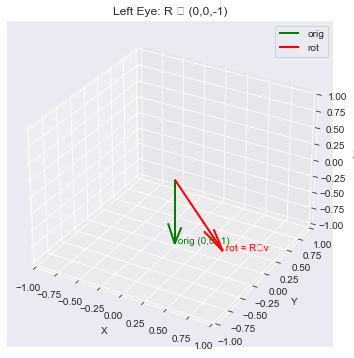

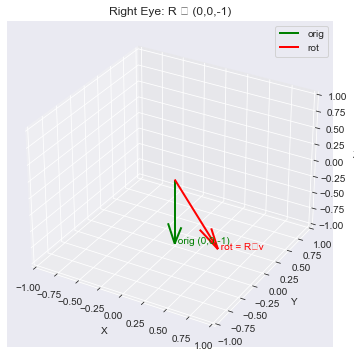

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # registers the 3D projection

def visualize_R(R, title="Rotation of Forward Vector"):
    """
    Given a 3×3 rotation matrix R, plot in 3D:
      • the original forward vector v = (0,0,-1) in green
      • the rotated vector R @ v            in red
    """
    # 1) Define the original “forward” vector (Blender camera looks down -Z).
    v = np.array([0.0, 0.0, -1.0])
    # 2) Rotate it.
    v_rot = R.dot(v)

    # 3) Set up a 3D plot.
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111, projection='3d')

    # 4) Draw the two arrows from the origin.
    # ‑ length=1 means draw them at their true length (they’re unit vectors).
    ax.quiver(0, 0, 0, 
              v[0], v[1], v[2], 
              color='green', length=1, normalize=False, linewidth=2, label='orig')
    ax.quiver(0, 0, 0, 
              v_rot[0], v_rot[1], v_rot[2], 
              color='red',   length=1, normalize=False, linewidth=2, label='rot')

    # 5) Annotate the tips for clarity.
    ax.text(   v[0],    v[1],    v[2],   ' orig (0,0,-1)', color='green')
    ax.text(v_rot[0], v_rot[1], v_rot[2], ' rot = R⋅v',     color='red')

    # 6) Make the axes equal‑scaled.
    lim = 1.0
    ax.set_xlim([-lim, lim])
    ax.set_ylim([-lim, lim])
    ax.set_zlim([-lim, lim])

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(title)
    ax.legend()
    plt.show()


# --- Usage example ---

# 1) Load one of your rotation matrices:
import json
def load_rot_matrix(path):
    with open(path) as f:
        M = np.array(json.load(f))
    return M

blender_project_path = pathlib.Path(r"D:\MarkS3\Documents\BlenderFiles\Camera_angle_registration\PV_57_textured-20250325T102628Z-001")
left_json_path = blender_project_path / "left_rot_matrix.json"
right_json_path = blender_project_path / "right_rot_matrix.json"

R_left  = load_rot_matrix(left_json_path)
R_right = load_rot_matrix(right_json_path)

# 2) Visualize:
visualize_R(R_left,  title="Left Eye: R ⋅ (0,0,-1)")
visualize_R(R_right, title="Right Eye: R ⋅ (0,0,-1)")


In [36]:
import json
import numpy as np
import plotly.graph_objects as go

def visualize_R_plotly_interactive(json_path, title="Rotation of Forward Vector"):
    """
    Load a 3x3 rotation matrix from JSON, then visualize:
      • Original forward vector (0,0,-1) in green (line + marker)
      • Rotated vector R @ (0,0,-1) in red
      • Arc between them in blue, with angle annotation
    using an interactive Plotly 3D scene.
    """
    # Load rotation matrix
    R = np.array(json.load(open(json_path, 'r')))
    
    # Define the original forward vector
    v = np.array([0.0, 0.0, -1.0])
    v_rot = R.dot(v)
    
    # Normalize for arc computation
    v_norm = v / np.linalg.norm(v)
    v_rot_norm = v_rot / np.linalg.norm(v_rot)
    
    # Compute angle between them
    cosang = np.dot(v_norm, v_rot_norm)
    cosang = np.clip(cosang, -1.0, 1.0)
    angle = np.degrees(np.arccos(cosang))
    
    # Compute rotation axis for arc (unit)
    axis = np.cross(v_norm, v_rot_norm)
    if np.linalg.norm(axis) < 1e-6:
        axis_unit = np.array([1,0,0])
    else:
        axis_unit = axis / np.linalg.norm(axis)
    
    # Generate points along the arc
    steps = 50
    thetas = np.linspace(0, np.radians(angle), steps)
    arc_points = []
    for t in thetas:
        # Rodrigues' rotation formula around axis_unit
        arc_vec = (v_norm * np.cos(t) +
                   np.cross(axis_unit, v_norm) * np.sin(t))
        arc_points.append(arc_vec)
    arc_points = np.array(arc_points)
    
    # Midpoint index for annotation
    mid = len(arc_points) // 2
    
    # Create Plotly figure
    fig = go.Figure()
    
    # Original vector line
    fig.add_trace(go.Scatter3d(
        x=[0, v[0]], y=[0, v[1]], z=[0, v[2]],
        mode='lines+markers',
        marker=dict(size=4, color='green'),
        line=dict(color='green', width=6),
        name='Original'
    ))
    
    # Rotated vector line
    fig.add_trace(go.Scatter3d(
        x=[0, v_rot[0]], y=[0, v_rot[1]], z=[0, v_rot[2]],
        mode='lines+markers',
        marker=dict(size=4, color='red'),
        line=dict(color='red', width=6),
        name='Rotated'
    ))
    
    # Angle arc
    fig.add_trace(go.Scatter3d(
        x=arc_points[:,0], y=arc_points[:,1], z=arc_points[:,2],
        mode='lines',
        line=dict(color='blue', width=4),
        name='Angle Arc'
    ))
    
    # Angle annotation at the midpoint
    fig.add_trace(go.Scatter3d(
        x=[arc_points[mid,0]], y=[arc_points[mid,1]], z=[arc_points[mid,2]],
        mode='text',
        text=[f'{angle:.1f}°'],
        textposition='middle right',
        showlegend=False
    ))
    
    # Layout
    fig.update_layout(
        scene=dict(
            xaxis=dict(range=[-1,1], title='X'),
            yaxis=dict(range=[-1,1], title='Y'),
            zaxis=dict(range=[-1,1], title='Z'),
            aspectmode='cube'
        ),
        title=f"{title}<br>Rotation angle = {angle:.2f}°",
    )
    
    fig.show()

# Example usage:
visualize_R_plotly_interactive(left_json_path, title="Left Eye Rotation")
# visualize_R_plotly_interactive("r_rot_matrix.json", title="Right Eye Rotation")


In [19]:
import numpy as np
import plotly.graph_objects as go

def visualize_with_horizon(df, R, subset=20, title="Gaze Vectors & Horizon on Eye Sphere"):
    """
    Visualize gaze vectors on the eye sphere, reference vector, and both
    original and rotated horizon axes.
    
    Parameters:
      df      : DataFrame with 'k_phi','k_theta','k_phi_corr','k_theta_corr'
      R       : 3x3 rotation matrix (NumPy array)
      subset  : number of gaze points to draw
      title   : plot title
    """
    # Convert angles to unit vectors
    def angles_to_vecs(phis, thetas):
        p = np.deg2rad(phis); t = np.deg2rad(thetas)
        x = np.cos(t) * np.cos(p)
        y = np.cos(t) * np.sin(p)
        z = np.sin(t)
        return np.vstack((x,y,z)).T

    vecs_orig = angles_to_vecs(df['k_phi'], df['k_theta'])
    vecs_corr = angles_to_vecs(df['k_phi_corr'], df['k_theta_corr'])

    # Camera forward and horizon axes in camera space
    v_cam = np.array([0,0,-1])
    orig_x = np.array([1,0,0])
    orig_y = np.array([0,1,0])

    # Map to anatomical frame
    v_ref   = R.dot(v_cam)
    x_rot   = R.dot(orig_x)
    y_rot   = R.dot(orig_y)

    # Sphere mesh
    u = np.linspace(0,2*np.pi,50)
    v = np.linspace(0,np.pi,50)
    uu, vv = np.meshgrid(u,v)
    xs = np.cos(uu)*np.sin(vv)
    ys = np.sin(uu)*np.sin(vv)
    zs = np.cos(vv)

    fig = go.Figure()

    # Sphere
    fig.add_trace(go.Surface(x=xs, y=ys, z=zs, opacity=0.2,
                             colorscale=[[0,'lightblue'],[1,'lightblue']], showscale=False,
                             name='Eye Sphere'))

    # Reference forward
    fig.add_trace(go.Scatter3d(x=[0, v_ref[0]], y=[0, v_ref[1]], z=[0, v_ref[2]],
                               mode='lines+markers', line=dict(color='blue', width=4),
                               marker=dict(size=5, color='blue'),
                               name='Ref Forward'))

    # Original horizon axes
    fig.add_trace(go.Scatter3d(x=[0, orig_x[0]], y=[0, orig_x[1]], z=[0, orig_x[2]],
                               mode='lines+markers', line=dict(color='black', width=3, dash='dash'),
                               marker=dict(size=4, color='black'),
                               name='Orig X-axis'))
    fig.add_trace(go.Scatter3d(x=[0, orig_y[0]], y=[0, orig_y[1]], z=[0, orig_y[2]],
                               mode='lines+markers', line=dict(color='black', width=3, dash='dash'),
                               marker=dict(size=4, color='black'),
                               name='Orig Y-axis'))

    # Rotated horizon axes
    fig.add_trace(go.Scatter3d(x=[0, x_rot[0]], y=[0, x_rot[1]], z=[0, x_rot[2]],
                               mode='lines+markers', line=dict(color='orange', width=4),
                               marker=dict(size=5, color='orange'),
                               name='Rot X-axis'))
    fig.add_trace(go.Scatter3d(x=[0, y_rot[0]], y=[0, y_rot[1]], z=[0, y_rot[2]],
                               mode='lines+markers', line=dict(color='purple', width=4),
                               marker=dict(size=5, color='purple'),
                               name='Rot Y-axis'))

    # Sample gaze points
    n = len(df); idxs = np.linspace(0, n-1, min(subset,n)).astype(int)
    for i, col in enumerate(['Original','Corrected']):
        pts = vecs_orig if col=='Original' else vecs_corr
        color = 'green' if col=='Original' else 'red'
        showleg = True if i==0 else False
        # plot points
        fig.add_trace(go.Scatter3d(
            x=pts[idxs,0], y=pts[idxs,1], z=pts[idxs,2],
            mode='markers', marker=dict(size=3, color=color),
            name=col, showlegend=showleg
        ))

    fig.update_layout(
        scene=dict(xaxis=dict(range=[-1,1]), yaxis=dict(range=[-1,1]), zaxis=dict(range=[-1,1]),
                   aspectmode='cube'),
        title=title
    )
    fig.show()

# Example usage:
visualize_with_horizon(corrected_left, R_left, subset=30)



In [25]:
import numpy as np
import plotly.graph_objects as go

def visualize_full_interactive(df, R, subset=30, arc_steps=20):
    """
    Interactive Plotly 3D visualization showing:
      - Unit sphere representing the eye
      - Two sets of reference axes:
          * Unrotated camera frame: X_red, Y_green, Z_blue
          * Rotated anatomical frame: X_purple, Y_yellow, Z_cyan
      - A subset of gaze vectors: original endpoints (small red),
        rotated endpoints (small green), and arcs (gray) between each pair.
    
    Parameters:
      df        : DataFrame with 'k_phi','k_theta','k_phi_corr','k_theta_corr'
      R         : 3x3 rotation matrix (NumPy array)
      subset    : number of gaze points to sample and display
      arc_steps : number of segments to draw each arc
    """
    # Helper: spherical linear interpolation (slerp) between v1, v2
    def compute_arc(v1, v2, steps):
        # Ensure normalized
        v1_u = v1 / np.linalg.norm(v1)
        v2_u = v2 / np.linalg.norm(v2)
        # angle between
        dot = np.clip(np.dot(v1_u, v2_u), -1.0, 1.0)
        omega = np.arccos(dot)
        if omega < 1e-6:
            return np.tile(v1_u, (steps,1))
        axis = np.cross(v1_u, v2_u)
        axis = axis / np.linalg.norm(axis)
        arc = []
        for t in np.linspace(0,1,steps):
            # Rodrigues rotation of v1 by angle t*omega about axis
            cos_t = np.cos(t*omega)
            sin_t = np.sin(t*omega)
            v = v1_u*cos_t + np.cross(axis, v1_u)*sin_t + axis*(axis.dot(v1_u))*(1-cos_t)
            arc.append(v)
        return np.array(arc)
    
    # Convert angles to vectors
    def to_vecs(phis, thetas):
        p = np.deg2rad(phis); t = np.deg2rad(thetas)
        x = np.cos(t)*np.cos(p)
        y = np.cos(t)*np.sin(p)
        z = np.sin(t)
        return np.vstack((x,y,z)).T

    vec_orig = to_vecs(df['k_phi'].values, df['k_theta'].values)
    vec_corr = to_vecs(df['k_phi_corr'].values, df['k_theta_corr'].values)
    
    # Reference axes in camera frame
    axes_cam = np.eye(3)
    # Rotated axes in anatomical frame
    axes_rot = R.dot(axes_cam.T).T

    # Sphere mesh
    u = np.linspace(0,2*np.pi,60)
    v = np.linspace(0,np.pi,30)
    uu, vv = np.meshgrid(u,v)
    xs = np.cos(uu)*np.sin(vv)
    ys = np.sin(uu)*np.sin(vv)
    zs = np.cos(vv)

    fig = go.Figure()

    # Eye sphere
    fig.add_trace(go.Surface(
        x=xs, y=ys, z=zs, opacity=0.2,
        colorscale=[[0,'lightgray'],[1,'lightgray']], showscale=False
    ))

    # Plot unrotated axes: X_red, Y_green, Z_blue
    colors_orig = ['red','green','blue']
    names_orig = ['Orig X','Orig Y','Orig Z']
    for i, col in enumerate(colors_orig):
        v = axes_cam[i]
        fig.add_trace(go.Scatter3d(
            x=[0,v[0]], y=[0,v[1]], z=[0,v[2]],
            mode='lines+markers', marker=dict(size=4,color=col),
            line=dict(color=col,width=4), name=names_orig[i]
        ))

    # Plot rotated axes: X_purple, Y_yellow, Z_cyan
    colors_rot = ['purple','yellow','cyan']
    names_rot = ['Rot X','Rot Y','Rot Z']
    for i, col in enumerate(colors_rot):
        v = axes_rot[i]
        fig.add_trace(go.Scatter3d(
            x=[0,v[0]], y=[0,v[1]], z=[0,v[2]],
            mode='lines+markers', marker=dict(size=4,color=col),
            line=dict(color=col,width=4), name=names_rot[i]
        ))

    # Subsample gaze points
    n = len(df)
    idxs = np.linspace(0,n-1,min(subset,n)).astype(int)
    # Plot original and corrected endpoints, arcs
    for idx in idxs:
        vo = vec_orig[idx]
        vc = vec_corr[idx]
        # original endpoint small red
        fig.add_trace(go.Scatter3d(
            x=[vo[0]], y=[vo[1]], z=[vo[2]],
            mode='markers', marker=dict(size=3,color='red'),
            showlegend=False
        ))
        # corrected endpoint small green
        fig.add_trace(go.Scatter3d(
            x=[vc[0]], y=[vc[1]], z=[vc[2]],
            mode='markers', marker=dict(size=3,color='green'),
            showlegend=False
        ))
        # arc
        arc = compute_arc(vo, vc, arc_steps)
        fig.add_trace(go.Scatter3d(
            x=arc[:,0], y=arc[:,1], z=arc[:,2],
            mode='lines', line=dict(color='gray',width=2),
            showlegend=False
        ))

    # Layout
    fig.update_layout(
        scene=dict(
            xaxis=dict(range=[-1,1],title='X'),
            yaxis=dict(range=[-1,1],title='Y'),
            zaxis=dict(range=[-1,1],title='Z'),
            aspectmode='cube'
        ),
        title="Sphere & Axes: Original vs Rotated (R)"
    )
    fig.update_layout(
    scene_camera=dict(
      eye=dict(x=1.5, y=1.5, z=1.5),
      center=dict(x=0, y=0, z=0),
      up=dict(x=0, y=0, z=1),
    )
    )
    fig.show()

# Example usage:
visualize_full_interactive(corrected_left, R_left, subset=300)


In [31]:
# when you have a specific block object to correct: 

# Provide paths to the rotation matrices (exported from Blender).
blender_project_path = pathlib.Path(r"D:\MarkS3\Documents\BlenderFiles\Camera_angle_registration\PV_57_textured-20250325T102628Z-001")
left_json_path = blender_project_path / "l_rot_matrix_v3.json"
right_json_path = blender_project_path / "r_rot_matrix_v3.json"

# Correct the gaze data.
corrected_left, corrected_right = correct_block_sync_data(block, left_json_path, right_json_path)

# For downstream inspection, you can now examine the corrected DataFrames.
print(corrected_left.head())
print(corrected_right.head())

# When you are satisfied, you may choose to update block.left_eye_data and block.right_eye_data:
# block.left_eye_data = corrected_left
# block.right_eye_data = corrected_right
#
# And, if desired, export the corrected dataframes to CSV:
# corrected_left.to_csv("left_eye_data_corrected.csv", index=False)
# corrected_right.to_csv("right_eye_data_corrected.csv", index=False)



   Unnamed: 0  Unnamed: 0.1  OE_timestamp  eye_frame   ms_axis    center_x  \
0           0             0     1466856.0        NaN  73342.80         NaN   
1           1             1     1467194.0        NaN  73359.70         NaN   
2           2             2     1467533.0        NaN  73376.65         NaN   
3           3             3     1467871.0        NaN  73393.55         NaN   
4           4             4     1468209.0        3.0  73410.45  426.092642   

     center_y        phi      width    height  ...  minor_ax     ratio  \
0         NaN        NaN        NaN       NaN  ...       NaN       NaN   
1         NaN        NaN        NaN       NaN  ...       NaN       NaN   
2         NaN        NaN        NaN       NaN  ...       NaN       NaN   
3         NaN        NaN        NaN       NaN  ...       NaN       NaN   
4  233.957706  175.37214  44.926339  39.30249  ...  39.30249  1.143091   

   pupil_diameter_pixels  pupil_diameter    ratio2  phi_ellipse      k_phi  \
0       

NameError: name 'corrected_right' is not defined

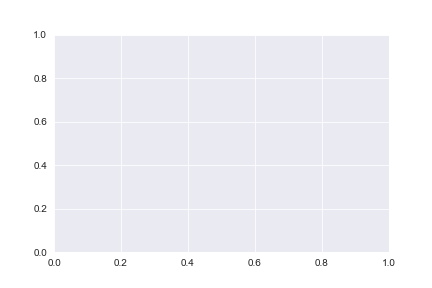

In [10]:
fig,ax = plt.subplots()
ax.scatter(corrected_right.k_phi_corr, corrected_right.k_theta_corr)
ax.set_xlim(-60,60)
ax.set_ylim(-60,60)
ax.set_aspect('equal')

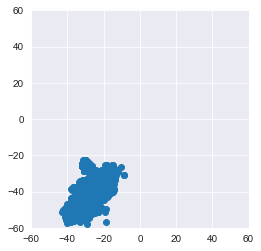

In [8]:
fig,ax = plt.subplots()
ax.scatter(corrected_right.k_phi, corrected_right.k_theta)
ax.set_xlim(-60,60)
ax.set_ylim(-60,60)
ax.set_aspect('equal')

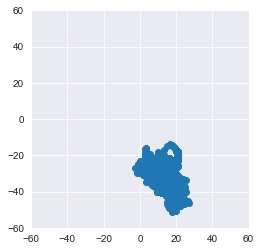

In [55]:
fig,ax = plt.subplots()
ax.scatter(corrected_left.k_phi, corrected_left.k_theta)
ax.set_xlim(-60,60)
ax.set_ylim(-60,60)
ax.set_aspect('equal')

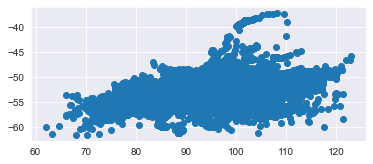

In [57]:
fig,ax = plt.subplots()
ax.scatter(corrected_left.k_phi_corr, corrected_left.k_theta_corr)
#ax.set_xlim(-60,60)
#ax.set_ylim(-60,60)
ax.set_aspect('equal')

In [14]:
# This ceates a verification plot for 
from bokeh.plotting import figure, show
from bokeh.layouts import column
from bokeh.models import ColumnDataSource


def plot_eye_comparison_over_time(eye_df):
    """
    Creates two interactive Bokeh line plots arranged vertically to compare 
    the twin datasets over time.
    
    The first plot displays:
      - center_x (pixel-based) and 
      - k_phi (angular, in degrees)
    against ms_axis (time in milliseconds).
    
    The second plot displays:
      - center_y (pixel-based) and 
      - k_theta (angular, in degrees)
    against ms_axis.
    
    Both plots include interactive tools (pan, zoom, box zoom, reset, save) and 
    allow you to zoom and pan through time.
    
    Parameters:
      eye_df : pandas.DataFrame
          DataFrame with columns:
            - 'ms_axis': Time in milliseconds.
            - 'center_x': Pixel-based x-coordinate.
            - 'center_y': Pixel-based y-coordinate.
            - 'k_phi': Angular phi (in degrees), analogous to center_x.
            - 'k_theta': Angular theta (in degrees), analogous to center_y.
    """

    # Create a ColumnDataSource for efficient plotting
    source = ColumnDataSource(eye_df)
    tools = "pan,wheel_zoom,box_zoom,reset,save"

    # Plot 1: ms_axis vs. center_x and k_phi
    p1 = figure(title="Time Series: center_x vs. k_phi",
                x_axis_label="Time (ms)",
                y_axis_label="center_x / k_phi",
                tools=tools, width=1500, height=1300)
    p1.line(x='ms_axis', y='k_phi', source=source, color="blue", legend_label="center_x", line_width=2)
    p1.line(x='ms_axis', y='k_phi_corr', source=source, color="red", legend_label="k_phi", line_width=2)
    p1.legend.location = "top_left"

    # Plot 2: ms_axis vs. center_y and k_theta
    p2 = figure(title="Time Series: center_y vs. k_theta",
                x_axis_label="Time (ms)",
                y_axis_label="center_y / k_theta",
                tools=tools, width=1500, height=1300)
    p2.line(x='ms_axis', y='k_theta', source=source, color="blue", legend_label="center_y", line_width=2)
    p2.line(x='ms_axis', y='k_theta_corr', source=source, color="red", legend_label="k_theta", line_width=2)
    p2.legend.location = "top_left"

    # Layout the plots in a vertical column and display them
    layout = column(p1, p2)
    show(layout)


plot_eye_comparison_over_time(corrected_right)


In [11]:
corrected_left.head()

Unnamed: 0  Unnamed: 0.1  OE_timestamp  eye_frame   ms_axis    center_x  \
0           0             0     1466856.0        NaN  73342.80         NaN   
1           1             1     1467194.0        NaN  73359.70         NaN   
2           2             2     1467533.0        NaN  73376.65         NaN   
3           3             3     1467871.0        NaN  73393.55         NaN   
4           4             4     1468209.0        3.0  73410.45  426.092642   

     center_y        phi      width    height  ...  minor_ax     ratio  \
0         NaN        NaN        NaN       NaN  ...       NaN       NaN   
1         NaN        NaN        NaN       NaN  ...       NaN       NaN   
2         NaN        NaN        NaN       NaN  ...       NaN       NaN   
3         NaN        NaN        NaN       NaN  ...       NaN       NaN   
4  233.957706  175.37214  44.926339  39.30249  ...  39.30249  1.143091   

   pupil_diameter_pixels  pupil_diameter    ratio2  phi_ellipse      k_phi  \
0                    NaN             NaN       NaN          NaN        NaN   
1                    NaN             NaN       NaN          NaN        NaN   
2                    NaN             NaN       NaN          NaN        NaN   
3                    NaN             NaN       NaN          NaN        NaN   
4              44.926339        1.545466  0.874821    175.37214  13.428502   

     k_theta  k_phi_corr  k_theta_corr  
0        NaN         NaN           NaN  
1        NaN         NaN           NaN  
2        NaN         NaN           NaN  
3        NaN         NaN           NaN  
4 -27.199145  101.487309    -49.844195  

[5 rows x 21 columns]

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_gaze_vectors(before, after, title="Gaze Correction Verification"):
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(121, projection='3d')
    ax.set_title("Original (Camera Frame)")
    ax.quiver(np.zeros(len(before)), np.zeros(len(before)), np.zeros(len(before)),
              before[:, 0], before[:, 1], before[:, 2], color='r', alpha=0.5)
    ax.set_xlim([-1, 1]); ax.set_ylim([-1, 1]); ax.set_zlim([-1, 1])

    ax2 = fig.add_subplot(122, projection='3d')
    ax2.set_title("Corrected (Anatomical Frame)")
    ax2.quiver(np.zeros(len(after)), np.zeros(len(after)), np.zeros(len(after)),
               after[:, 0], after[:, 1], after[:, 2], color='g', alpha=0.5)
    ax2.set_xlim([-1, 1]); ax2.set_ylim([-1, 1]); ax2.set_zlim([-1, 1])

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()
plot_gaze_vectors(l_vectors, l_rotated, title="Left Eye Gaze Correction")
plot_gaze_vectors(r_vectors, r_rotated, title="Right Eye Gaze Correction")


In [ ]:
# from here, another attempt:

# Jupyter Notebook Pipeline: Correct Gaze Vectors Using Rotation Matrix

import numpy as np
import pandas as pd

# --- Functions ---
def spherical_to_cartesian(k_phi, k_theta):
    phi = np.radians(k_phi)
    theta = np.radians(k_theta)
    x = np.cos(theta) * np.cos(phi)
    y = np.cos(theta) * np.sin(phi)
    z = np.sin(theta)
    return np.stack((x, y, z), axis=-1)

def apply_rotation(vectors, rotation_matrix):
    return vectors @ rotation_matrix.T

def cartesian_to_spherical(vectors):
    x, y, z = vectors[:, 0], vectors[:, 1], vectors[:, 2]
    r = np.linalg.norm(vectors, axis=1)
    k_theta = np.arcsin(z / r)
    k_phi = np.arctan2(y, x)
    return np.degrees(k_phi), np.degrees(k_theta)

# --- Load Data ---
left_eye_data = pd.read_csv("left_eye_data.csv")
right_eye_data = pd.read_csv("right_eye_data.csv")

# --- Load Rotation Matrices ---
l_rotation_matrix = np.loadtxt("left_eye_rotation_matrix.txt")
r_rotation_matrix = np.loadtxt("right_eye_rotation_matrix.txt")

# --- Process Left Eye ---
l_vectors = spherical_to_cartesian(left_eye_data['k_phi'], left_eye_data['k_theta'])
l_rotated = apply_rotation(l_vectors, l_rotation_matrix)
l_phi_corr, l_theta_corr = cartesian_to_spherical(l_rotated)
left_eye_data['k_phi_corrected'] = l_phi_corr
left_eye_data['k_theta_corrected'] = l_theta_corr

# --- Process Right Eye ---
r_vectors = spherical_to_cartesian(right_eye_data['k_phi'], right_eye_data['k_theta'])
r_rotated = apply_rotation(r_vectors, r_rotation_matrix)
r_phi_corr, r_theta_corr = cartesian_to_spherical(r_rotated)
right_eye_data['k_phi_corrected'] = r_phi_corr
right_eye_data['k_theta_corrected'] = r_theta_corr

# --- Save Updated Data ---
left_eye_data.to_csv("left_eye_data_corrected.csv", index=False)
right_eye_data.to_csv("right_eye_data_corrected.csv", index=False)

print("Gaze correction complete.")


In [24]:
# try again, 20/04

# ==============================================================================
# Python Analysis Functions: Apply and Visualize Correction
# =====================================================================
# These functions can be imported into your Jupyter pipeline.
# ------------------------------------------------------------------------------
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt


def load_rot_matrix(path):
    with open(path,'r') as f: return np.array(json.load(f))


def angles_to_vecs(phi, theta):
    p = np.deg2rad(phi); t = np.deg2rad(theta)
    x = np.cos(t)*np.cos(p)
    y = np.cos(t)*np.sin(p)
    z = np.sin(t)
    return np.vstack((x,y,z)).T


def vecs_to_angles(v):
    x,y,z = v[:,0], v[:,1], v[:,2]
    phi = np.rad2deg(np.arctan2(y,x))
    r = np.linalg.norm(v,axis=1)
    theta = np.rad2deg(np.arcsin(np.clip(z/r, -1,1)))
    return phi, theta


def apply_correction(df, mat, mirror=False):
    """
    df: DataFrame with 'k_phi','k_theta'
    mat: 3x3 rotation matrix
    mirror: if True, flip phi sign (for left eye)
    """
    V = angles_to_vecs(df['k_phi'], df['k_theta'])
    Vc = V @ mat.T
    phi_c, theta_c = vecs_to_angles(Vc)
    if mirror:
        phi_c = -phi_c
    df['k_phi_corr'] = phi_c
    df['k_theta_corr'] = theta_c
    return df


def visualize_average(df, title='Average Gaze'):
    """
    Compute mean gaze vector and visualize original vs corrected axes.
    """
    # Mean original
    Vox = angles_to_vecs(df['k_phi'], df['k_theta'])
    mean_orig = Vox.mean(axis=0)
    # Mean corrected
    Vc = angles_to_vecs(df['k_phi_corr'], df['k_theta_corr'])
    mean_corr = Vc.mean(axis=0)
    import matplotlib.pyplot as plt
    
    # pick a small sample
    sub = df.iloc[::len(df)//50]  # 50 points
    Vox_sub = angles_to_vecs(sub['k_phi'], sub['k_theta'])
    Voxc_sub = angles_to_vecs(sub['k_phi_corr'], sub['k_theta_corr'])
    
    plt.scatter(Vox_sub[:,0], Vox_sub[:,1], label='orig')
    plt.scatter(Voxc_sub[:,0], Voxc_sub[:,1], label='corr')
    plt.legend(); plt.axis('equal'); plt.show()

    print("Mean original (φ, θ):", df[["k_phi","k_theta"]].mean().values)
    print("Mean corrected (φ, θ):", df[["k_phi_corr","k_theta_corr"]].mean().values)
    fig, ax = plt.subplots(figsize=(5,5))
    ax.quiver(0,0, mean_orig[0], mean_orig[1], color='blue', label='Orig')
    ax.quiver(0,0, mean_corr[0], mean_corr[1], color='red', label='Corr')
    ax.set_xlim(-1,1); ax.set_ylim(-1,1)
    ax.set_aspect('equal'); ax.grid(True)
    ax.legend(); ax.set_title(title)
    plt.show()

In [14]:
# Provide paths to the rotation matrices (exported from Blender).
blender_project_path = pathlib.Path(r"D:\MarkS3\Documents\BlenderFiles\Camera_angle_registration\PV_57_textured-20250325T102628Z-001")
left_json_path = blender_project_path / "l_rot_matrix.json"
right_json_path = blender_project_path / "r_rot_matrix.json"

In [15]:
left_df = block.left_eye_data.copy()
right_df = block.right_eye_data.copy()

R_left = load_rot_matrix(left_json_path)
R_right = load_rot_matrix(right_json_path)

left_corr_df  = apply_correction(left_df.copy(),  R_left,  mirror=False)
right_corr_df = apply_correction(right_df.copy(), R_right, mirror=False)


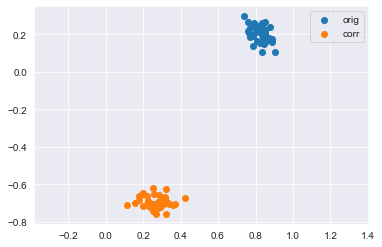

Mean original (φ, θ): [ 13.98059834 -31.19588937]
Mean corrected (φ, θ): [-69.08331071 -41.32374677]


c:\users\marks3\pycharmprojects\pythonproject3\venv\lib\site-packages\matplotlib\quiver.py:628: RuntimeWarning: Mean of empty slice.
  amean = a[~self.Umask].mean()
c:\users\marks3\pycharmprojects\pythonproject3\venv\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


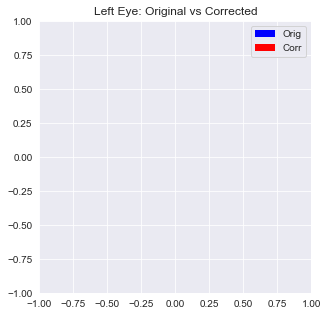

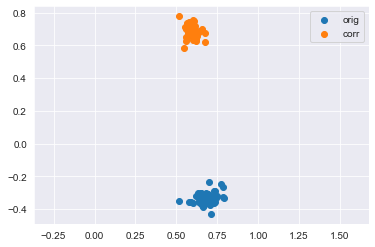

Mean original (φ, θ): [-26.78471375 -40.85589928]
Mean corrected (φ, θ): [ 48.9155478 -25.1004286]


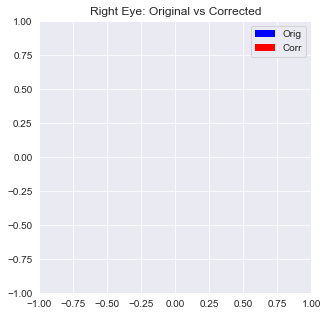

In [25]:
visualize_average(left_corr_df,  title='Left Eye: Original vs Corrected')
visualize_average(right_corr_df, title='Right Eye: Original vs Corrected')


NameError: name 'df' is not defined